In [128]:
run_para='kaggle'
if run_para=='local':
    adress='kaggle'
else:
    adress='/kaggle'
    !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
    !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
    !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages


In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import lightgbm as lgb
import warnings
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.impute import SimpleImputer
from tabpfn import TabPFNClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import log_evaluation
import pickle
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")


In [130]:
train = pd.read_csv(adress+'/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv(adress+'/input/icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv(adress+'/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv(adress+'/input/icr-identify-age-related-conditions/greeks.csv')
first_category = train.EJ.unique()[0]
train.EJ = train.EJ.eq(first_category).astype('int')
test.EJ = test.EJ.eq(first_category).astype('int')

In [131]:
int_denominators = {
    'AB': 0.004273,
    'AF': 0.00242,
    'AH': 0.008709,
    'AM': 0.003097,
    'AR': 0.005244,
    'AX': 0.008859,
    'AY': 0.000609,
    'AZ': 0.006302,
    'BC': 0.007028,
    'BD ': 0.00799,
    'BN': 0.3531,
    'BP': 0.004239,
    'BQ': 0.002605,
    'BR': 0.006049,
    'BZ': 0.004267,
    'CB': 0.009191,
    'CC': 6.12e-06,
    'CD ': 0.007928,
    'CF': 0.003041,
    'CH': 0.000398,
    'CL': 0.006365,
    'CR': 7.5e-05,
    'CS': 0.003487,
    'CU': 0.005517,
    'CW ': 9.2e-05,
    'DA': 0.00388,
    'DE': 0.004435,
    'DF': 0.000351,
    'DH': 0.002733,
    'DI': 0.003765,
    'DL': 0.00212,
    'DN': 0.003412,
    'DU': 0.0013794,
    'DV': 0.00259,
    'DY': 0.004492,
    'EB': 0.007068,
    'EE': 0.004031,
    'EG': 0.006025,
    'EH': 0.006084,
    'EL': 0.000429,
    'EP': 0.009269,
    'EU': 0.005064,
    'FC': 0.005712,
    'FD ': 0.005937,
    'FE': 0.007486,
    'FI': 0.005513,
    'FR': 0.00058,
    'FS': 0.006773,
    'GB': 0.009302,
    'GE': 0.004417,
    'GF': 0.004374,
    'GH': 0.003721,
    'GI': 0.002572
}
for k, v in int_denominators.items():
    train[k] = np.round(train[k] / v, 1)
    test[k] = np.round(test[k] / v, 1)

In [132]:
from sklearn.cluster import KMeans

def categorical_cut(k,feature):
    k = 5
    global run_para
    if run_para == 'kaggle':
        BNpd = pd.concat([train[feature], test[feature]], axis=0, ignore_index=True)
    elif run_para == 'local':
        BNpd = train[feature]
    BNpd = pd.concat([train[feature], test[feature]], axis=0, ignore_index=True)
    data = BNpd.values.reshape(-1, 1)
    kmodel = KMeans(n_clusters=k)           # k为聚成几类
    kmodel.fit(data)  # 训练模型
    c = pd.DataFrame(kmodel.cluster_centers_, columns=['cc']) #求聚类中心
    c0 = pd.DataFrame({'cc': [0.0]})
    c = pd.concat([c0, c], axis=0, ignore_index=True)
    c = c.sort_values(by='cc').reset_index(drop=True)
    for i in range(c.shape[0] - 1): #in range 5
        c.iloc[i]['cc'] = (c.iloc[i]['cc'] + c.iloc[i+1]['cc']) / 2 #take average of now and next center
    c = c.drop(c.index[-1])
    c0 = pd.DataFrame({'cc': [0.0]}) #center at 0
    cn = pd.DataFrame({'cc': [max(train[feature].max(), test[feature].max()) * 5]}) #center large enough
    c = pd.concat([c0, c, cn], axis=0, ignore_index=True)
    c = c['cc'].round().astype(int)
    c = c.unique()
    range_num = c.shape[0] - 1 #5
    c = c.tolist()
    train_BN = train[feature].values #list
    train_binning = pd.cut(train_BN, c, labels=range(range_num), include_lowest=True) #cut according to range
    train[feature+'binning'] = train_binning.astype(int)
    test_BN = test[feature].values
    test_binning = pd.cut(test_BN, c, labels=range(range_num), include_lowest=True)
    test[feature+'binning'] = test_binning.astype(int)
    print('fininsh cutting '+feature+', split by:', c)
categorical_cut(5,'AB')
#categorical_cut(5,'DH')
#categorical_cut(8,'DE')
#categorical_cut(7,'GF')
train

fininsh cutting AB, split by: [0, 31, 102, 210, 414, 855, 7210]


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,ABbinning
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0,1
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0,2
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0,1
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,2174.0,10.0,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0,1
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,2142.0,63.0,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0,1
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,857.0,10.0,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0,1
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,1358.0,99.0,2644.0,16439.0,449324.0,6750.0,14446.0,0.184622,0,1


In [133]:
predictor_columns = [n for n in train.columns if n != 'Class' and n != 'Id']
from datetime import datetime
greeks.Alpha=greeks.Alpha.replace({'A':0, 'B': 1,'D': 2,'G': 3})
time = greeks.Epsilon.copy().replace({'Unknown':np.nan})
times = pd.to_datetime(time,format='%m/%d/%Y')
#times
Year=times.dt.year
train_pred_and_time = pd.concat((train, Year, greeks.Alpha), axis=1)
train_pred_and_time

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Class,ABbinning,Epsilon,Alpha
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1,1,2019.0,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0,1,NaN,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0,2,NaN,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0,1,NaN,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1,1,2020.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0,1,2020.0,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0,1,2020.0,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0,1,2019.0,0
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,2644.0,16439.0,449324.0,6750.0,14446.0,0.184622,0,1,2019.0,0


In [134]:
train_year = train_pred_and_time[~(train_pred_and_time['Epsilon'].isna())]
test_year = train_pred_and_time[(train_pred_and_time['Epsilon'].isna())]
train_year['Epsilon']=train_year['Epsilon']-2012
X_year = train_year.drop(['Id','Class','Epsilon','Alpha'],axis=1)
y_year = train_year['Epsilon']
np.unique(y_year)

array([0., 2., 4., 5., 6., 7., 8.])

In [135]:
train_year

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Class,ABbinning,Epsilon,Alpha
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1,1,7.0,1
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1,1,8.0,2
5,04517a3c90bd,49.0,1080915.0,9783.0,2758.0,1552.0,453.0,42.0,1991.0,175.0,...,2356.0,16439.0,5527571.0,7666.0,32087.0,21.978000,0,1,7.0,0
6,049232ca8356,81.5,716386.0,9783.0,2705.0,2920.0,216.0,42.0,1039.0,175.0,...,1922.0,43571.0,761881.0,9182.0,38914.0,0.065096,0,1,7.0,0
7,057287f2da6d,63.0,399361.5,9783.0,6837.0,1552.0,563.0,42.0,1493.0,175.0,...,1983.0,24834.5,4886090.5,9462.0,12218.0,0.092873,0,1,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,41.0,1077383.0,9783.0,2282.0,1552.0,455.0,42.0,539.0,175.0,...,1818.0,55715.0,2505799.0,10314.5,15944.0,21.978000,0,1,8.0,0
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0,1,8.0,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0,1,8.0,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0,1,7.0,0


In [136]:
from sklearn.model_selection import train_test_split
train_year_X, val_year_X, train_year_y, val_year_y = train_test_split(X_year, y_year, random_state = 2,test_size=0.2)
import xgboost as xgb
params ={'learning_rate': 0.3,
          'max_depth': 15,                # 构建树的深度，越大越容易过拟合
          #'num_boost_round':10000,
          'objective': 'multi:softprob', # 多分类的问题
          'random_state': 7,
          #'silent':0,
          'num_class':9,                 # 类别数，与 multisoftmax 并用
          'eta':0.8                      #为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
        }
model = xgb.train(params,xgb.DMatrix(train_year_X, train_year_y))
val_pred_y = model.predict(xgb.DMatrix(val_year_X))
val_pred_y_label = np.argmax(val_pred_y, axis=1)
err = val_year_y - val_pred_y_label
acc = np.sum(err == 0)/len(val_year_y)
acc

0.7789473684210526

In [137]:
test_pred_y = model.predict(xgb.DMatrix(test_year.drop(['Id','Class','Epsilon','Alpha'],axis=1)))
test_pred_y_label = np.argmax(test_pred_y, axis=1)
test_year['Epsilon'] = test_pred_y_label
train_pred_and_time = pd.concat([test_year,train_year],axis = 0)
train_pred_and_time=train_pred_and_time.sort_index(axis=0)
train_pred_and_time

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Class,ABbinning,Epsilon,Alpha
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1,1,7.0,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0,1,7.0,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0,2,7.0,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0,1,7.0,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1,1,8.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0,1,8.0,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0,1,8.0,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0,1,7.0,0
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,2644.0,16439.0,449324.0,6750.0,14446.0,0.184622,0,1,7.0,0


In [138]:
test_predictors = test[predictor_columns]
test_time = np.zeros((len(test_predictors), 1)) + train_pred_and_time.Epsilon.max() + 1
test_pred_and_time = pd.concat((test_predictors, pd.DataFrame(test_time, columns=['Epsilon'])), axis=1)
test_pred_and_time

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,ABbinning,Epsilon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.0


In [139]:
def plot_distribution(data):
    target_col = 'Class'
    num_cols = 4
    num_rows = len(train_pred_and_time.columns) // num_cols +1
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4*num_rows))
    sns.set(font_scale=1.2, style='whitegrid')

    for i, col_name in enumerate(train_pred_and_time.columns):
        if col_name != 'Class':
            ax = axes[i // num_cols, i % num_cols]
            #print(col_name)
            sns.kdeplot(data=data, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)
            # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)
            ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=14)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_col.title(), fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.legend([1, 0], title=target_col.title(), fontsize=12)

    plt.tight_layout()
    plt.show()
#train_pred_and_time = train_pred_and_time.drop(['Id'],axis=1)
train_pred_and_time['Dh+Ee'] = train_pred_and_time['DH']+0.1*train_pred_and_time['EE'] #0.198
test_pred_and_time['Dh+Ee'] = test_pred_and_time['DH']+0.1*test_pred_and_time['EE']
train_pred_and_time['DA*CS'] = np.log(train_pred_and_time['DA']*2 / train_pred_and_time['CS']**0.5)
test_pred_and_time['DA*CS'] = np.log(test_pred_and_time['DA']*2 / test_pred_and_time['CS']**0.5)
def change_GL(X):
        X['out_GL'] = 0
        X.loc[X['GL']<1,'out_GL'] = X.loc[X['GL']<1,'GL'].map(lambda x : x-X.loc[X['GL']<1,'GL'].mean())
        X.loc[X['GL']>1.5,'out_GL'] = X.loc[X['GL']>1.5,'GL'].map(lambda x : x-X.loc[X['GL']>1.5,'GL'].mean())
        X.out_GL = X.out_GL.astype('float')
change_GL(train_pred_and_time)
change_GL(test_pred_and_time)
#X['DA*CS'] = np.log(X.DA*2 / X.CS**0.5)
#train_pred_and_time['Dh+Ee+Gf'] = train_pred_and_time['DH']+0.1*train_pred_and_time['EE']+400*train_pred_and_time['GF']
#train_pred_and_time['Eu_s'] = train_pred_and_time['EU']*1e10
#plot_distribution(train_pred_and_time)

In [140]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

train_pred_and_time_copy = train_pred_and_time.copy()
test_pred_and_time_copy = test_pred_and_time.copy()

x = train_pred_and_time_copy .fillna(-1)
x.drop(['Id', 'EJ', 'Class'], axis=1, inplace=True)

# Run simple TSNE
tsne = TSNE(2)
tsne_result = tsne.fit_transform(x)
print(len(tsne_result))

# 2-fold KNN model
knn1 = KNeighborsClassifier(20)
knn2 = KNeighborsClassifier(20)
knn_model1 = knn1.fit(tsne_result[308:, ], train_pred_and_time_copy ['Class'][308:])
knn_model2 = knn2.fit(tsne_result[:308, ], train_pred_and_time_copy ['Class'][:308])

oof = knn_model1.predict_proba(tsne_result[:308, ])[:, 1].tolist() + knn_model2.predict_proba(tsne_result[308:, ])[:, 1].tolist()

res = pd.DataFrame({'prob': oof, 'class': train_pred_and_time_copy ['Class']})

train_pred_and_time_copy ['hard'] = 0
display_conditions = ((res['class'] == 0) & (res['prob'] == 1)) | ((res['class'] == 1) & (res['prob'] == 0))
train_pred_and_time_copy .loc[display_conditions, 'hard'] = 1

display(train_pred_and_time_copy )
print(train_pred_and_time_copy ['hard'].value_counts())

617


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GI,GL,Class,ABbinning,Epsilon,Alpha,Dh+Ee,DA*CS,out_GL,hard
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,27152.0,0.120343,1,1,7.0,1,153.3,6.339267,-0.052655,0
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,12493.0,21.978000,0,1,7.0,0,154.3,6.003922,2.608559,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,13683.0,0.196941,0,2,7.0,0,279.1,5.839412,0.023943,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,35184.0,0.155829,0,1,7.0,0,201.6,5.413500,-0.017170,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,14099.0,0.096614,1,1,8.0,2,162.6,5.992110,-0.076384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,26902.0,21.978000,0,1,8.0,0,196.6,4.649307,2.608559,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,48526.0,0.145340,0,1,8.0,0,178.7,5.355254,-0.027658,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,46485.0,21.978000,0,1,7.0,0,195.2,6.229613,2.608559,0
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,14446.0,0.184622,0,1,7.0,0,241.4,5.579787,0.011623,0


0    610
1      7
Name: hard, dtype: int64


In [141]:
to_keep = ['DU', 'BQ', 'AB', 'DA', 'CR', 'FR', 'CC', 'AF', 'EU', 'DE', 
           'DN', 'DL', 'CH', 'GH', 'EL', 'FE','EH', 'EP', 'DI', 'Id', 'Class', 'hard','Dh+Ee','DA*CS','out_GL']

train_pred_and_time_copy = train_pred_and_time_copy[to_keep]

In [142]:
train_pred_and_time_copy

,DU,BQ,AB,DA,CR,FR,CC,AF,EU,DE,...,FE,EH,EP,DI,Id,Class,hard,Dh+Ee,DA*CS,out_GL
0,3850.0,58621.0,49.0,17805.0,923.0,2997.5,92072.0,1284724.5,756.0,66645.0,...,1206023.5,156.0,8472.0,23704.0,000ff2bfdfe9,1,0,153.3,6.339267,-0.052655
1,4.0,5664.0,34.0,18247.0,14904.0,857.0,79201.0,404448.0,10320.0,40260.0,...,906359.0,0.5,10294.0,29371.0,007255e47698,0,0,154.3,6.003922,2.608559
2,935.0,84192.0,110.0,18252.5,9338.0,1682.0,81021.5,1088887.0,1064.5,72475.0,...,1113933.5,62.0,8472.0,31887.5,013f2bd269f5,0,0,279.1,5.839412,0.023943
3,1925.0,4242.0,59.0,12184.5,8481.0,857.0,117301.0,1578368.5,6185.5,44331.0,...,1464836.5,101.0,8472.0,37138.0,043ac50845d5,0,0,201.6,5.413500,-0.017170
4,830.0,57473.0,89.0,19089.0,9242.0,83623.0,87658.0,1542582.0,10099.0,45136.0,...,2163779.0,27.0,9925.0,26008.0,044fb8a146ec,1,0,162.6,5.992110,-0.076384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,4.0,10475.0,35.0,5608.0,9310.0,2174.0,112950.5,1293413.0,12998.0,80255.0,...,2293242.0,0.5,8472.0,47006.0,fd3dafe738fd,0,0,196.6,4.649307,2.608559
613,470.0,132301.0,102.0,11317.0,10147.0,2142.0,126193.5,2257039.0,88400.0,35489.0,...,2465980.5,23.0,12385.5,51155.0,fd895603f071,0,0,178.7,5.355254,-0.027658
614,4.0,39919.0,100.0,26964.0,11731.0,857.0,115787.0,1016160.0,756.0,50329.0,...,679792.0,0.5,9429.0,58145.0,fd8ef6377f76,0,0,195.2,6.229613,2.608559
615,370.0,NaN,85.0,13155.0,7775.0,1358.0,98407.5,522122.0,1631.0,25298.0,...,863512.0,23.0,10757.0,30153.0,fe1942975e40,0,0,241.4,5.579787,0.011623


In [143]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Best Parameters: {'C': 0.05, 'fit_intercept': True, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Custom Metric Score: 0.5704918032786885
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       610
           1       0.05      0.43      0.09         7

    accuracy                           0.90       617
   macro avg       0.52      0.67      0.52       617
weighted avg       0.98      0.90      0.94       617



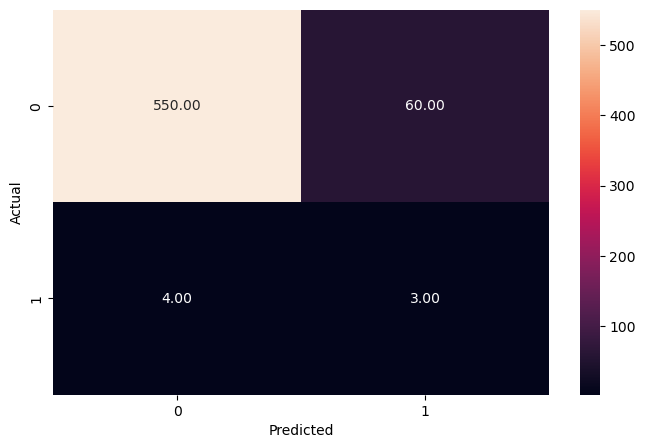


0.15
0.8601639344262295
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       610
           1       0.07      0.86      0.13         7

    accuracy                           0.87       617
   macro avg       0.53      0.86      0.53       617
weighted avg       0.99      0.87      0.92       617



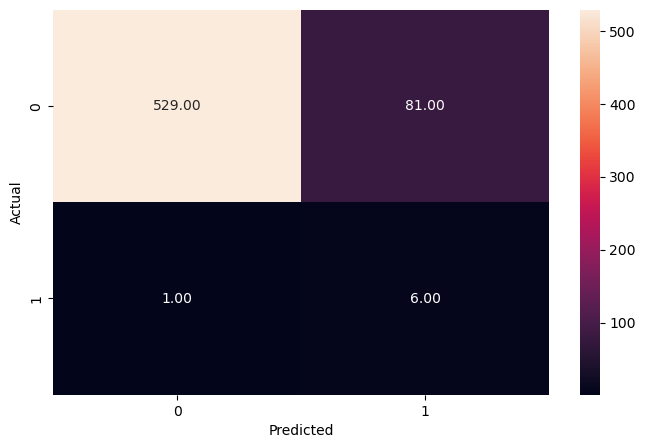

In [144]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

X = train_pred_and_time_copy.drop(columns=['Id', 'Class', 'hard'])
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

y = train_pred_and_time_copy['hard']

def true_positive_to_false_positive(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    # Weighted average of sensitivity and specificity
    # Adjust the weights as per your requirements
    metric_score = (0.7 * sensitivity) + (0.3 * specificity)

    return metric_score

custom_metric = make_scorer(true_positive_to_false_positive, greater_is_better=True)

class_weights = {0: 8, 1: 609}
model = LogisticRegression(class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

"""
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  #l1_ratio not needed for elasticnet bc its not choosen
    'C': [0.04, 0.05, 0.06],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [200, 300, 400],
}
"""
#param_grid = {'C': [0.1], 'fit_intercept': [True], 'max_iter': [300], 'penalty': ['l2'], 'solver': ['liblinear']}
param_grid = {'C': [0.05], 'fit_intercept': [True], 'max_iter': [300], 'penalty': ['l2'], 'solver': ['lbfgs']}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring=custom_metric)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

y_pred = cross_val_predict(best_model, X, y, cv=skf)
custom_score = true_positive_to_false_positive(y, y_pred)
print("Custom Metric Score:", custom_score)

metrics_score(y, y_pred)

best_threshold = 0
best_temp_score = 0.0

for i in np.arange(0.0,1.0,0.01):
    y_pred_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')
    y_pred = (y_pred_proba[:, 1] >= i).astype(int)
    temp_score = true_positive_to_false_positive(y, y_pred)
    if temp_score >= best_temp_score:
        best_temp_score = temp_score
        best_threshold = i
        
print()        
print(best_threshold)
print(best_temp_score)

y_pred_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')
y_pred = (y_pred_proba[:, 1] >= best_threshold).astype(int)
metrics_score(y, y_pred)

In [145]:
x

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GF,GH,GI,GL,ABbinning,Epsilon,Alpha,Dh+Ee,DA*CS,out_GL
0,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,516469.0,...,458118.5,5949.0,27152.0,0.120343,1,7.0,1,153.3,6.339267,-0.052655
1,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,687976.0,...,6397248.0,7830.0,12493.0,21.978000,1,7.0,0,154.3,6.003922,2.608559
2,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,642776.0,...,3126876.5,7531.0,13683.0,0.196941,2,7.0,0,279.1,5.839412,0.023943
3,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,521862.0,...,478798.0,10736.0,35184.0,0.155829,1,7.0,0,201.6,5.413500,-0.017170
4,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,716988.0,...,1948873.0,12196.0,14099.0,0.096614,1,8.0,2,162.6,5.992110,-0.076384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,520361.0,...,1850922.0,6622.0,26902.0,21.978000,1,8.0,0,196.6,4.649307,2.608559
613,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,707644.0,...,705374.5,7968.0,48526.0,0.145340,1,8.0,0,178.7,5.355254,-0.027658
614,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,737031.0,...,1480259.0,7032.0,46485.0,21.978000,1,7.0,0,195.2,6.229613,2.608559
615,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,565440.0,...,449324.0,6750.0,14446.0,0.184622,1,7.0,0,241.4,5.579787,0.011623


In [146]:
y_pred_train_proba=best_model.predict(x[['DU', 'BQ', 'AB', 'DA', 'CR', 'FR', 'CC', 'AF', 'EU', 'DE', 
           'DN', 'DL', 'CH', 'GH', 'EL', 'FE','EH', 'EP', 'DI','Dh+Ee','DA*CS','out_GL']])
#y_train_pred = (y_pred_train_proba[:, 1] >= 0.9).astype(int)
train_pred_and_time['hard']=y_pred_train_proba
train_pred_and_time

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GI,GL,Class,ABbinning,Epsilon,Alpha,Dh+Ee,DA*CS,out_GL,hard
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,27152.0,0.120343,1,1,7.0,1,153.3,6.339267,-0.052655,0
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,12493.0,21.978000,0,1,7.0,0,154.3,6.003922,2.608559,1
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,13683.0,0.196941,0,2,7.0,0,279.1,5.839412,0.023943,1
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,35184.0,0.155829,0,1,7.0,0,201.6,5.413500,-0.017170,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,14099.0,0.096614,1,1,8.0,2,162.6,5.992110,-0.076384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,26902.0,21.978000,0,1,8.0,0,196.6,4.649307,2.608559,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,48526.0,0.145340,0,1,8.0,0,178.7,5.355254,-0.027658,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,46485.0,21.978000,0,1,7.0,0,195.2,6.229613,2.608559,1
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,14446.0,0.184622,0,1,7.0,0,241.4,5.579787,0.011623,0


In [147]:
test_pred_and_time_copy=test_pred_and_time.copy()
imputer = SimpleImputer(strategy='median')
XxX = test_pred_and_time_copy.fillna(0)
y_pred_test_proba=best_model.predict(XxX[['DU', 'BQ', 'AB', 'DA', 'CR', 'FR', 'CC', 'AF', 'EU', 'DE', 
           'DN', 'DL', 'CH', 'GH', 'EL', 'FE','EH', 'EP', 'DI','Dh+Ee','DA*CS','out_GL']])

#y_test_pred = (y_pred_test_proba[:, 1] >= 0.6).astype(int)
test_pred_and_time['hard']=y_pred_test_proba
1-y_pred_test_proba

array([0, 0, 0, 0, 0])

In [148]:
x_ = train_pred_and_time.drop(['Class', 'Id','Alpha','DV','BC','FD ','EJ','DF','AR'], axis=1)
test_pred_and_time = test_pred_and_time.drop(['DV','BC','FD ','EJ','DF','AR'], axis=1)#'DV','BC','FD ','EJ','DF','AR'
y_ = train_pred_and_time.Class
y_alpha = train_pred_and_time.Alpha

In [149]:
def data_process1(x):
    ft = ['AB' ,'AH' ,'AY' ,'BN' ,'BQ' ,'BR' ,'CC' ,'CR' ,'DE' ,'DI' ,'DY' ,'EE' ,'EG' ,'EH' 
          ,'FI' ,'FL' ,'FR' ,'GI'  ,'DA*CS','Dh+Ee','out_GL']#,'hard','DU'
    out=x[ft]
    return out
def data_process2(x):
    ft = ['AB' ,'AM' ,'BQ' ,'CB' ,'CC' ,'CD ' ,'CH' ,'CR' ,'DA' ,'DE' ,'DL' ,'DN' 
          ,'DU' ,'DY' ,'EB' ,'EE' ,'EL' ,'EU'  ,'FI' ,'FL' ,'FR' ,'FS' ,'GH'
          ,'DA*CS','Dh+Ee','out_GL']#,'FE'
    out=x[ft]
    return out
def data_process3(x):
    ft = ['AB', 'AF', 'AH', 'AM', 'AX', 'AY', 'AZ', 'BD ', 'BN', 'BP', 'BQ',
       'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DH', 'DI', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE',
       'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FE', 'FI', 'FL', 'FR', 'FS',
       'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 
       'Dh+Ee', 'DA*CS', 'out_GL','Epsilon']#,'hard'
    out=x[ft]
    return out

In [150]:
'''def model_test(classifier,x_,y_):
    if 'LGBMClassifier' in str(classifier):
            selector = SelectFromModel(estimator=classifier).fit(x_,y_)
    elif 'CatBoostClassifier' in str(classifier):
        selector = SelectFromModel(estimator=classifier).fit(x_,y_,verbose=False)
    elif 'XGBClassifier' in str(classifier):
        selector = SelectFromModel(estimator=classifier).fit(x_,y_,verbose=False)
    elif 'TabPFNClassifier' in str(classifier):
        selector = SelectFromModel(estimator=classifier).fit(x_,y_,overwrite_warning=True)
    else :
        selector = SelectFromModel(estimator=classifier).fit(x_,y_)
    col = x_.columns.values
    select = selector.get_support()
    indx = np.argwhere(select==True)
    indx = indx.flatten()
    return indx
indx_xgb = model_test(XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.2,subsample=0.9,colsample_bytree=0.85),x_,y_)
indx_lgb = model_test(LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000,
                          random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',verbose=-1,
                         metric='none', max_depth=8),x_,y_)
fea_xgb = x_.columns.values[indx_xgb]
fea_lgb = x_.columns.values[indx_lgb]
print(fea_xgb)
print(fea_lgb)'''

"def model_test(classifier,x_,y_):\n    if 'LGBMClassifier' in str(classifier):\n            selector = SelectFromModel(estimator=classifier).fit(x_,y_)\n    elif 'CatBoostClassifier' in str(classifier):\n        selector = SelectFromModel(estimator=classifier).fit(x_,y_,verbose=False)\n    elif 'XGBClassifier' in str(classifier):\n        selector = SelectFromModel(estimator=classifier).fit(x_,y_,verbose=False)\n    elif 'TabPFNClassifier' in str(classifier):\n        selector = SelectFromModel(estimator=classifier).fit(x_,y_,overwrite_warning=True)\n    else :\n        selector = SelectFromModel(estimator=classifier).fit(x_,y_)\n    col = x_.columns.values\n    select = selector.get_support()\n    indx = np.argwhere(select==True)\n    indx = indx.flatten()\n    return indx\nindx_xgb = model_test(XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.2,subsample=0.9,colsample_bytree=0.85),x_,y_)\nindx_lgb = model_test(LGBMClassifier(boosting_type='goss', learning_rate=0.0673323295

In [151]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class

    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = (w_0 * log_loss_0 + w_1 * log_loss_1)
    # return the average log loss
    return balanced_log_loss/2

In [152]:
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
def lgb_metric(y_true, y_pred):
    y_pred_copy=y_pred.copy()
    probabilities = np.concatenate((y_pred_copy[:,:1], np.sum(y_pred_copy[:,1:], 1, keepdims=True)), axis=1)
    p0 = probabilities[:,1]
    
    return 'balanced_log_loss', balanced_log_loss(y_true, p0), False

class Ensemble():
    def __init__(self,X,y_alpha):
        self.X=X
        self.y_alpha=y_alpha
        self.classifiers =[XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.2,subsample=0.9,colsample_bytree=0.85),
                   LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000,
                          random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',verbose=-1,
                         metric='none', max_depth=8),TabPFNClassifier(N_ensemble_configurations=48)
                   ]#CatBoostClassifier(iterations=10000,learning_rate= 0.003,depth=4,auto_class_weights='Balanced',loss_function='MultiClass')
        X_train_total,X_val_total, y_train_total, y_val_total =train_test_split(X,y_alpha,test_size=0.20, random_state=0)
        self.train_dataset=[X_train_total,y_train_total]
        self.y_train_true=np.clip(y_train_total,0,1).astype(int)
        y_val_true=np.clip(y_val_total,0,1).astype(int)
        self.eval=[X_val_total,y_val_total]
        self.y_val_true=y_val_true
        self.stack_model=CatBoostClassifier(iterations=300,depth=3)
        self.probabilities=None
    def fit(self):
        scores = []
        skf = StratifiedKFold(n_splits=5)
        flag = 0
        score=100
        X_train_total,y_train_total=self.train_dataset
        X_val_total,y_val_total=self.eval

        for train_index, test_index in skf.split(X_train_total, y_train_total):
            print(flag)
            X_train, y_train = X_train_total.iloc[train_index], y_train_total.iloc[train_index]
            X_val, y_val = X_train_total.iloc[test_index], y_train_total.iloc[test_index]
            y_true_val=self.y_train_true.iloc[test_index]
            #ros=RandomOverSampler(random_state=42)
            #X_train, y_train=ros.fit_resample(X_train, y_train)
            for classifier in self.classifiers:
                if 'LGBMClassifier' in str(classifier):
                    classifier.fit(data_process2(X_train),y_train)
                elif 'CatBoostClassifier' in str(classifier):
                    classifier.fit(data_process1(X_train),y_train,verbose=False)
                elif 'XGBClassifier' in str(classifier):
                    classifier.fit(data_process1(X_train),y_train,verbose=False)
                elif 'TabPFNClassifier' in str(classifier):
                    classifier.fit(data_process3(X_train),y_train,overwrite_warning=True)
                else :
                    classifier.fit(data_process1(X_train),y_train)

            #self.stack(X_train,y_train)
            y_pred=self.predict_proba(X_val)
            #y_eval_predict=yt.predict_proba(yt.eval[0])
            y_eval_true=y_true_val.copy()
            prob=yt.probabilities
            dataframe_predict=pd.DataFrame()
            dataframe_predict['true']=y_eval_true
            dataframe_predict['ensemble']=1-y_pred[:,0]
            dataframe_predict['model0_1']=1-prob[0,:,0]
            dataframe_predict['model1_1']=1-prob[1,:,0]
            dataframe_predict['model2_1']=1-prob[2,:,0]
            #dataframe_predict['model3_1']=self.hard_predict
            dataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')
            dataframe_sort_predict=dataframe_sort_predict.reset_index()
            num_val=len(dataframe_sort_predict['ensemble'])
            plt.scatter(range(num_val),dataframe_sort_predict['ensemble'],label='ensemble',s=5)
            plt.scatter(range(num_val),dataframe_sort_predict['model0_1'],label='0',s=5)
            plt.scatter(range(num_val),dataframe_sort_predict['model1_1'],label='1',s=5)
            plt.scatter(range(num_val),dataframe_sort_predict['model2_1'],label='2',s=5)
            #plt.scatter(range(num_val),dataframe_sort_predict['model3_1'],label='3',s=5)
            plt.scatter(range(num_val),dataframe_sort_predict['true'],label='true',s=10)
            plt.legend()
            plt.show()
            val_score  = balanced_log_loss(y_true_val,y_pred[:,1])
            print(val_score)
            #val_score = balanced_log_loss(y_val, final_prob[:,1])
            scores.append(val_score)
            flag+=1
        mean, std = np.mean(scores), np.std(scores)
        return scores,mean,std
    def fit_test(self):
        X_train,y_train=self.train_dataset
        X_val_total,y_val_total=self.eval
        #ros=RandomOverSampler(random_state=42)
        #X_train, y_train=ros.fit_resample(X_train, y_train)
        for classifier in self.classifiers:
            if 'LGBMClassifier' in str(classifier):
                classifier.fit(data_process2(X_train),y_train)
            elif 'CatBoostClassifier' in str(classifier):
                classifier.fit(data_process1(X_train),y_train,verbose=False)
            elif 'XGBClassifier' in str(classifier):
                classifier.fit(data_process1(X_train),y_train,verbose=False)
            elif 'TabPFNClassifier' in str(classifier):
                classifier.fit(data_process3(X_train),y_train,overwrite_warning=True)
            else :
                classifier.fit(data_process1(X_train),y_train)
        #self.stack(X_train,y_train)
        y_pred=self.predict_proba(X_val_total)
        val_score  = balanced_log_loss(self.y_val_true,y_pred[:,1])
        print(val_score)
    def fit_whole(self):
        X_train,y_train=self.X,self.y_alpha
        #X_val_total,y_val_total=self.eval
        #ros=RandomOverSampler(random_state=42)
        #X_train, y_train=ros.fit_resample(X_train, y_train)
        for classifier in self.classifiers:
            if 'LGBMClassifier' in str(classifier):
                classifier.fit(data_process2(X_train),y_train)
            elif 'CatBoostClassifier' in str(classifier):
                classifier.fit(data_process1(X_train),y_train,verbose=False)
            elif 'XGBClassifier' in str(classifier):
                classifier.fit(data_process1(X_train),y_train,verbose=False)
            elif 'TabPFNClassifier' in str(classifier):
                classifier.fit(data_process3(X_train),y_train,overwrite_warning=True)
            else :
                classifier.fit(data_process1(X_train),y_train)
        #self.stack(X_train,y_train)
        #y_pred=self.predict_proba(X_val_total)
        #val_score  = balanced_log_loss(self.y_val_true,y_pred[:,1])
        #print(val_score)
    def predict_proba(self, x):
        yy=[]
        for classifier in self.classifiers:
            if 'LGBMClassifier' in str(classifier):
                yy.append(classifier.predict_proba(data_process2(x)))
            elif 'CatBoostClassifier' in str(classifier):
                yy.append(classifier.predict_proba(data_process1(x)))
            elif 'XGBClassifier' in str(classifier):
                yy.append(classifier.predict_proba(data_process1(x)))
            elif 'TabPFNClassifier' in str(classifier):
                yy.append(classifier.predict_proba(data_process3(x)))
            else :
                yy.append(classifier.predict_proba(data_process1(x)))
        probabilities = np.stack(yy)
        self.probabilities=probabilities
        #weight=np.array([0.3,0.3,0.3])
        averaged_probabilities = np.average(probabilities ,axis=0)
        #return averaged_probabilities

        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        #Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        #return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)
        final_prob =  new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)
        #final_prob = averaged_probabilities

        '''for prob in final_prob:
            if prob[0]<1e-2:
                prob[0] = 1e-2
                prob[1] = 1 - prob[0]
            elif prob[0]>1-1e-2:
                prob[1] = 1e-2
                prob[2] = 0
                prob[3] = 0
                prob[0] = 1 - prob[1]
'''
        final_prob = self.adjust(final_prob,x)
        final_probabilities = np.concatenate((final_prob[:,:1], np.sum(final_prob[:,1:], 1, keepdims=True)), axis=1)
        return final_probabilities
    
    def adjust(self,final_prob,x):
        probs=[]
        probs=self.probabilities
        '''for i in range(len(self.classifiers)):
            probs.append(self.probabilities[i,:,:])'''
        for i in range(len(final_prob)):
            #print(probabilities[:,i])
            if final_prob[i,0]<0.05:
                final_prob[i] = np.average([final_prob[i],probs[0,i,:],probs[1,i,:],probs[2,i,:]], weights=np.array([1,0,0,0]),axis=0)
            elif final_prob[i,0]>0.85 and final_prob[i,0]<0.93:
                final_prob[i] = np.average([final_prob[i],probs[0,i,:],probs[1,i,:],probs[2,i,:]], weights=np.array([1,1,2,1]),axis=0)
            else :
                final_prob[i] = np.average([final_prob[i],probs[0,i,:],probs[1,i,:],probs[2,i,:]], weights=np.array([1,0,0,0]),axis=0)
        return final_prob  #print(probabilities[1,:])


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
0


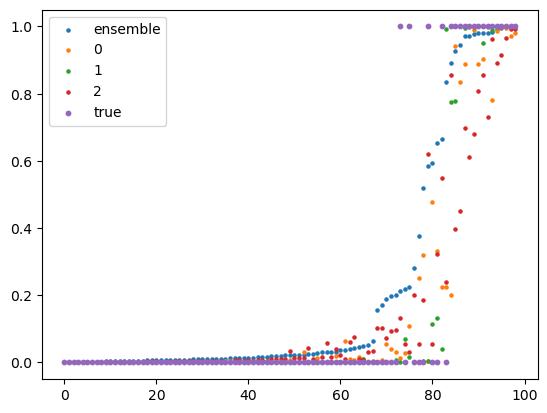

0.16383536660205303
1


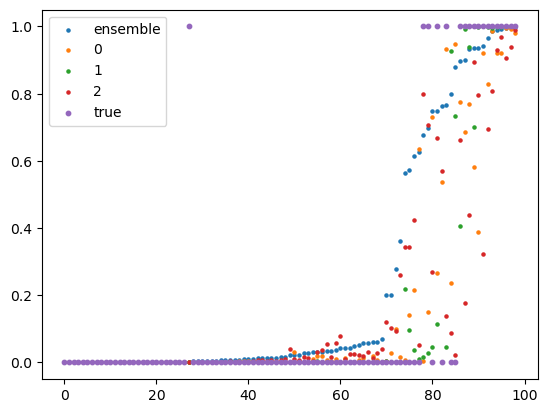

0.2917100293191025
2


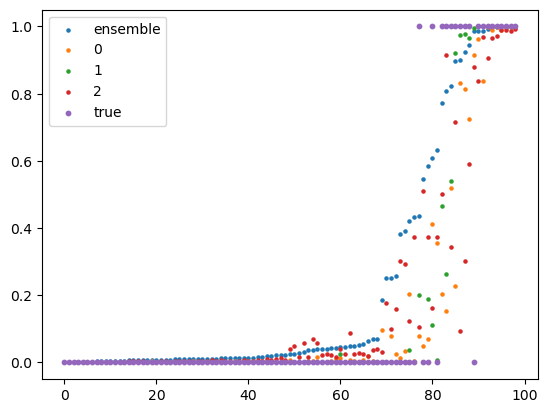

0.1370838038652316
3


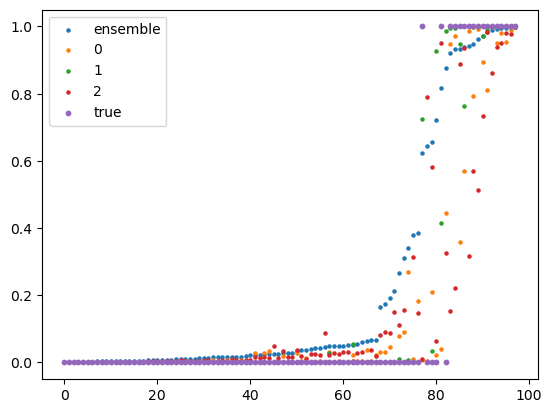

0.09568862684693298
4


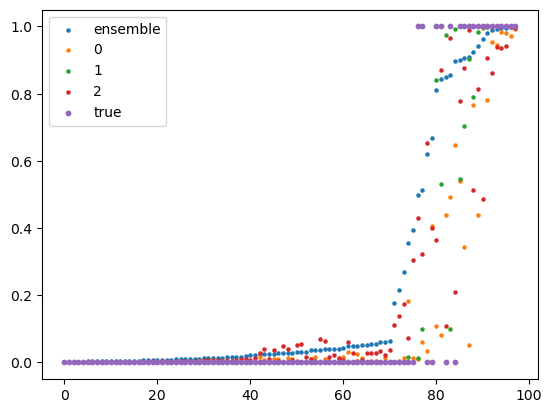

0.12691011663825358


([0.16383536660205303,
  0.2917100293191025,
  0.1370838038652316,
  0.09568862684693298,
  0.12691011663825358],
 0.16304558865431473,
 0.06792924105562893)

In [153]:
yt=Ensemble(x_,y_alpha)#0.27,0.261
yt.fit()
#yt.stack(X,y)

In [154]:
yt.fit_test()

0.22820156715463835


In [155]:
#yt.eval[0]['hard'][29:30]

In [156]:
#y_eval_predict=yt.predict_proba(yt.eval[0])

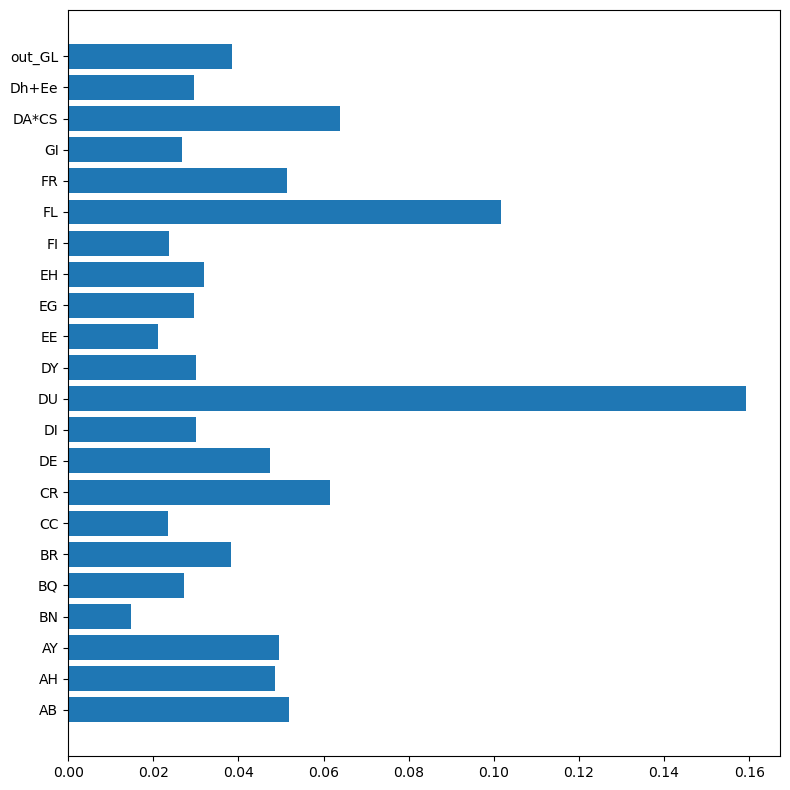

In [157]:
fig, ax = plt.subplots(figsize=(8,8))
plt.barh(data_process1(yt.eval[0]).columns, yt.classifiers[0].feature_importances_)

plt.tight_layout()
plt.show()

In [158]:
'''fig, ax = plt.subplots(figsize=(8,8))
plt.barh(data_process2(yt.eval[0]).columns, yt.classifiers[1].feature_importances_)

plt.tight_layout()
plt.show()'''

'fig, ax = plt.subplots(figsize=(8,8))\nplt.barh(data_process2(yt.eval[0]).columns, yt.classifiers[1].feature_importances_)\n\nplt.tight_layout()\nplt.show()'

In [159]:
#yt.fit_whole()

In [160]:
'''#y_eval_predict=yt.predict_proba(yt.eval[0])
y_eval_true=yt.y_val_true.copy()
prob=yt.probabilities
dataframe_predict=pd.DataFrame()
dataframe_predict['true']=y_eval_true
dataframe_predict['ensemble']=1-y_eval_predict[:,0]-y_eval_true
dataframe_predict['model0_1']=1-prob[0,:,0]-y_eval_true
dataframe_predict['model1_1']=1-prob[1,:,0]-y_eval_true
dataframe_predict['model2_1']=1-prob[2,:,0]-y_eval_true
dataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')
dataframe_sort_predict=dataframe_sort_predict.reset_index()
plt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['ensemble'],label='ensemble',s=5)
plt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model0_1'],label='0',s=5)
plt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model1_1'],label='1',s=5)
plt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model2_1'],label='2',s=5)
plt.legend()'''

"#y_eval_predict=yt.predict_proba(yt.eval[0])\ny_eval_true=yt.y_val_true.copy()\nprob=yt.probabilities\ndataframe_predict=pd.DataFrame()\ndataframe_predict['true']=y_eval_true\ndataframe_predict['ensemble']=1-y_eval_predict[:,0]-y_eval_true\ndataframe_predict['model0_1']=1-prob[0,:,0]-y_eval_true\ndataframe_predict['model1_1']=1-prob[1,:,0]-y_eval_true\ndataframe_predict['model2_1']=1-prob[2,:,0]-y_eval_true\ndataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')\ndataframe_sort_predict=dataframe_sort_predict.reset_index()\nplt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['ensemble'],label='ensemble',s=5)\nplt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model0_1'],label='0',s=5)\nplt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model1_1'],label='1',s=5)\nplt.scatter(dataframe_sort_predict['index'],dataframe_sort_predict['model2_1'],label='2',s=5)\nplt.legend()"

In [161]:
'''#y_eval_predict=yt.predict_proba(yt.eval[0])
y_eval_true=yt.y_val_true.copy()
prob=yt.probabilities
dataframe_predict=pd.DataFrame()
dataframe_predict['true']=y_eval_true
dataframe_predict['ensemble']=1-y_eval_predict[:,0]
dataframe_predict['model0_1']=1-prob[0,:,0]-dataframe_predict['ensemble']
dataframe_predict['model1_1']=1-prob[1,:,0]-dataframe_predict['ensemble']
dataframe_predict['model2_1']=1-prob[2,:,0]-dataframe_predict['ensemble']
dataframe_sort_predict=dataframe_predict.sort_values(by='true')
dataframe_sort_predict=dataframe_sort_predict.reset_index()
plt.scatter(range(124),dataframe_sort_predict['ensemble'],label='ensemble',s=5)
plt.scatter(range(124),dataframe_sort_predict['model0_1'],label='0',s=5)
plt.scatter(range(124),dataframe_sort_predict['model1_1'],label='1',s=5)
plt.scatter(range(124),dataframe_sort_predict['model2_1'],label='2',s=5)
plt.scatter(range(124),dataframe_sort_predict['true'],label='true',s=10)
plt.legend()'''

"#y_eval_predict=yt.predict_proba(yt.eval[0])\ny_eval_true=yt.y_val_true.copy()\nprob=yt.probabilities\ndataframe_predict=pd.DataFrame()\ndataframe_predict['true']=y_eval_true\ndataframe_predict['ensemble']=1-y_eval_predict[:,0]\ndataframe_predict['model0_1']=1-prob[0,:,0]-dataframe_predict['ensemble']\ndataframe_predict['model1_1']=1-prob[1,:,0]-dataframe_predict['ensemble']\ndataframe_predict['model2_1']=1-prob[2,:,0]-dataframe_predict['ensemble']\ndataframe_sort_predict=dataframe_predict.sort_values(by='true')\ndataframe_sort_predict=dataframe_sort_predict.reset_index()\nplt.scatter(range(124),dataframe_sort_predict['ensemble'],label='ensemble',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model0_1'],label='0',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model1_1'],label='1',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model2_1'],label='2',s=5)\nplt.scatter(range(124),dataframe_sort_predict['true'],label='true',s=10)\nplt.legend()"

In [162]:
'''#y_eval_predict=yt.predict_proba(yt.eval[0])
y_eval_true=yt.y_val_true.copy()
prob=yt.probabilities
dataframe_predict=pd.DataFrame()
dataframe_predict['true']=y_eval_true
dataframe_predict['ensemble']=1-y_eval_predict[:,0]
dataframe_predict['model0_1']=1-prob[0,:,0]
dataframe_predict['model1_1']=1-prob[1,:,0]
dataframe_predict['model2_1']=1-prob[2,:,0]
dataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')
dataframe_sort_predict=dataframe_sort_predict.reset_index()
plt.scatter(range(124),dataframe_sort_predict['ensemble'],label='ensemble',s=5)
plt.scatter(range(124),dataframe_sort_predict['model0_1'],label='0',s=5)
plt.scatter(range(124),dataframe_sort_predict['model1_1'],label='1',s=5)
plt.scatter(range(124),dataframe_sort_predict['model2_1'],label='2',s=5)
plt.scatter(range(124),dataframe_sort_predict['true'],label='true',s=10)
plt.legend()'''

"#y_eval_predict=yt.predict_proba(yt.eval[0])\ny_eval_true=yt.y_val_true.copy()\nprob=yt.probabilities\ndataframe_predict=pd.DataFrame()\ndataframe_predict['true']=y_eval_true\ndataframe_predict['ensemble']=1-y_eval_predict[:,0]\ndataframe_predict['model0_1']=1-prob[0,:,0]\ndataframe_predict['model1_1']=1-prob[1,:,0]\ndataframe_predict['model2_1']=1-prob[2,:,0]\ndataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')\ndataframe_sort_predict=dataframe_sort_predict.reset_index()\nplt.scatter(range(124),dataframe_sort_predict['ensemble'],label='ensemble',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model0_1'],label='0',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model1_1'],label='1',s=5)\nplt.scatter(range(124),dataframe_sort_predict['model2_1'],label='2',s=5)\nplt.scatter(range(124),dataframe_sort_predict['true'],label='true',s=10)\nplt.legend()"

In [163]:
#dataframe_predict

In [164]:
'''prob=yt.probabilities
y_eval_true=yt.y_val_true.copy()
dataframe_predict=pd.DataFrame()
dataframe_predict['true']=y_eval_true
dataframe_predict['ensemble']=1-y_eval_predict[:,0]
dataframe_predict['model0_1']=1-prob[0,:,0]
dataframe_predict['model1_1']=1-prob[1,:,0]
dataframe_predict['model2_1']=1-prob[2,:,0]
dataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')
dataframe_sort_predict=dataframe_sort_predict.reset_index()
num_val=len(dataframe_sort_predict['ensemble'])
plt.scatter(range(num_val),dataframe_sort_predict['ensemble'],label='ensemble',s=5)
plt.scatter(range(num_val),dataframe_sort_predict['model0_1'],label='0',s=5)
plt.scatter(range(num_val),dataframe_sort_predict['model1_1'],label='1',s=5)
plt.scatter(range(num_val),dataframe_sort_predict['model2_1'],label='2',s=5)
plt.scatter(range(num_val),dataframe_sort_predict['true'],label='true',s=10)
plt.legend()
plt.show()'''

"prob=yt.probabilities\ny_eval_true=yt.y_val_true.copy()\ndataframe_predict=pd.DataFrame()\ndataframe_predict['true']=y_eval_true\ndataframe_predict['ensemble']=1-y_eval_predict[:,0]\ndataframe_predict['model0_1']=1-prob[0,:,0]\ndataframe_predict['model1_1']=1-prob[1,:,0]\ndataframe_predict['model2_1']=1-prob[2,:,0]\ndataframe_sort_predict=dataframe_predict.sort_values(by='ensemble')\ndataframe_sort_predict=dataframe_sort_predict.reset_index()\nnum_val=len(dataframe_sort_predict['ensemble'])\nplt.scatter(range(num_val),dataframe_sort_predict['ensemble'],label='ensemble',s=5)\nplt.scatter(range(num_val),dataframe_sort_predict['model0_1'],label='0',s=5)\nplt.scatter(range(num_val),dataframe_sort_predict['model1_1'],label='1',s=5)\nplt.scatter(range(num_val),dataframe_sort_predict['model2_1'],label='2',s=5)\nplt.scatter(range(num_val),dataframe_sort_predict['true'],label='true',s=10)\nplt.legend()\nplt.show()"

In [165]:
'''fig = plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(231)
prob=yt.probabilities
for model_indx in range(len(yt.classifiers)):
    probi = 1-prob[model_indx,:,0]
    val_score = balanced_log_loss(yt.y_val_true, probi)
    print('for model',model_indx,'the score is:',val_score)
    probi.sort()
    #print(model_indx)
    indx = [i/len(probi) for i in range(len(probi))]
    #plt.subplot(int('22'+str(model_indx+1)))
    plt.plot(indx,probi,label=str(model_indx))
ensem = 1-y_eval_predict[:,0]
ensem.sort()
plt.plot(indx,ensem,label='ensemble')
plt.legend()
for model_indx in range(len(yt.classifiers)):
    plt.subplot(int('23'+str(model_indx+2)))
    probi = 1-prob[model_indx,:,0]
    pred_label = [0 if probi[i]<0.5 else 1 for i in range(len(yt.y_val_true))]
    wrong_prob = np.array(pred_label-yt.y_val_true)
    #print(np.array(wrong_prob))
    wrong_prob1 = np.argwhere(wrong_prob==1)
    wrong_prob1 = probi[wrong_prob1]
    wrong_prob0 = np.argwhere(wrong_prob==-1)
    wrong_prob0 = probi[wrong_prob0]
    plt.hist(wrong_prob1,alpha=0.5,label=str(model_indx)+'predict 0 as 1')
    plt.hist(wrong_prob0,alpha=0.5,label=str(model_indx)+'predict 1 as 0')
    plt.legend()
plt.subplot(236)
probi = 1-y_eval_predict[:,0]
pred_label = [0 if probi[i]<0.5 else 1 for i in range(len(yt.y_val_true))]
wrong_prob = np.array(pred_label-yt.y_val_true)
wrong_prob1 = np.argwhere(wrong_prob==1)
wrong_prob1 = probi[wrong_prob1]
wrong_prob0 = np.argwhere(wrong_prob==-1)
wrong_prob0 = probi[wrong_prob0]
plt.hist(wrong_prob1,alpha=0.5,label='ensemble'+'predict 0 as 1')
plt.hist(wrong_prob0,alpha=0.5,label='ensemble'+'predict 1 as 0')
plt.legend()

plt.show()'''

"fig = plt.figure(figsize=(12, 4), dpi=200)\nplt.subplot(231)\nprob=yt.probabilities\nfor model_indx in range(len(yt.classifiers)):\n    probi = 1-prob[model_indx,:,0]\n    val_score = balanced_log_loss(yt.y_val_true, probi)\n    print('for model',model_indx,'the score is:',val_score)\n    probi.sort()\n    #print(model_indx)\n    indx = [i/len(probi) for i in range(len(probi))]\n    #plt.subplot(int('22'+str(model_indx+1)))\n    plt.plot(indx,probi,label=str(model_indx))\nensem = 1-y_eval_predict[:,0]\nensem.sort()\nplt.plot(indx,ensem,label='ensemble')\nplt.legend()\nfor model_indx in range(len(yt.classifiers)):\n    plt.subplot(int('23'+str(model_indx+2)))\n    probi = 1-prob[model_indx,:,0]\n    pred_label = [0 if probi[i]<0.5 else 1 for i in range(len(yt.y_val_true))]\n    wrong_prob = np.array(pred_label-yt.y_val_true)\n    #print(np.array(wrong_prob))\n    wrong_prob1 = np.argwhere(wrong_prob==1)\n    wrong_prob1 = probi[wrong_prob1]\n    wrong_prob0 = np.argwhere(wrong_prob==-1

In [166]:
preds = yt.predict_proba(test_pred_and_time)
preds

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [167]:
sample=pd.read_csv(adress+'/input/icr-identify-age-related-conditions/sample_submission.csv')
testres=preds.T[0]
sample['class_1']=1-testres
sample['class_0']=testres

In [168]:
sample.to_csv(adress+'/working/submission.csv',index=False)

In [169]:
sample

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
